## Alerts for geomagnetic storms 

uses environment 'envs/env_alert.yml'

In [2]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
from datetime import timedelta
import seaborn as sns
import urllib
import pandas as pd
import os
import sys
import importlib
import email
import smtplib
import requests

from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

from alerts import alert_server_ids as aid

#Dst threshold definition for defining an alert
threshold=-30 #for real time application

#greater 0 means yes
telegram=1



##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    from config_server import data_path
    matplotlib.use('Agg') 
   
        
#mac
if sys.platform =='darwin':  
    print('system is mac')
    from config_local import data_path    
    #matplotlib.use('Agg') 
    %matplotlib inline     

print(data_path)

os.system('jupyter nbconvert --to script alert.ipynb')  





system is mac
/Users/chris/python/data/insitu_python/


[NbConvertApp] Converting notebook alert.ipynb to script
[NbConvertApp] Writing 7715 bytes to alert.py


0

### get Dst data and plot

14.0 -82.0


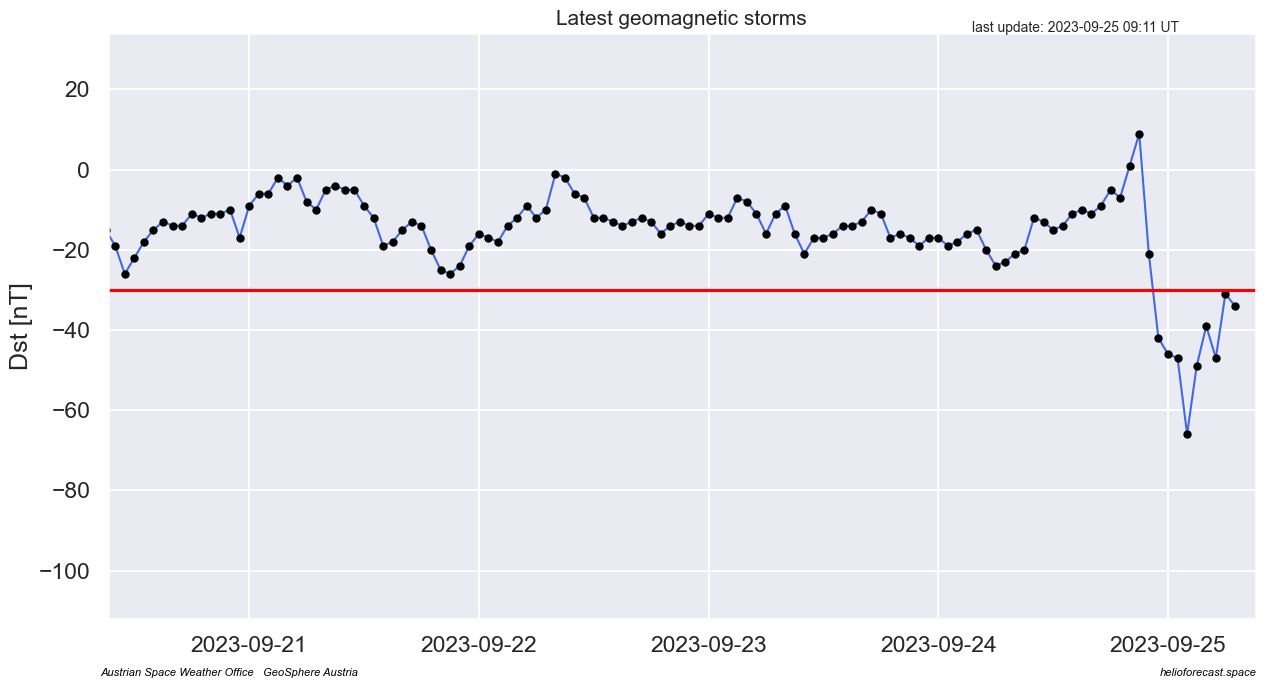

In [7]:
#get current dst last 35 days
filenoaa='noaa_dst_last_35files_now.p'
n=pickle.load(open(data_path+filenoaa, "rb" ) )  



## TBD load Nc values from Dst file


sns.set_context('talk')
sns.set_style('darkgrid')
fig, ax1=plt.subplots(1,figsize=(13,7),dpi=100)

ax1.plot(n.time,n.dst,color='royalblue',linewidth=1.5,alpha=1.0)
ax1.plot(n.time,n.dst,'ok',markersize=5)
ax1.axhline(y=threshold, color='r', linestyle='-')


plotmin=np.nanmin(n.dst)
plotmax=np.nanmax(n.dst)
print(plotmax, plotmin)


ax1.set_ylim(plotmin-30,plotmax+20)
plt.ylabel('Dst [nT]')
ax1.xaxis_date()

ax1.set_xlim(datetime.datetime.utcnow()-datetime.timedelta(days=20),datetime.datetime.utcnow()+datetime.timedelta(days=10))
ax1.set_xlim(datetime.datetime.utcnow()-datetime.timedelta(days=5),datetime.datetime.utcnow()+datetime.timedelta(days=0))

#plt.title('Geomagnetische Stürme 2015-2023')
plt.title('Latest geomagnetic storms',fontsize=15)

fsize=12

plt.figtext(0.09,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.98,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')
plt.figtext(0.92,0.93,'last update: '+str(datetime.datetime.utcnow())[0:16]+ ' UT', ha='right', fontsize=10)
plt.tight_layout()


plt.savefig('alerts/alert_dst.png',dpi=100)

### alert functions

In [8]:
def send_alert_email(time,dstval):

    ######### get email list from file if needed
    #email_file_path='alerts/alert_email_list.txt'
    #with open(email_file_path, "r") as file:
    #    email_list = []
    #    for line in file:
    #        # Remove leading and trailing whitespace (e.g., newline characters)
    #        string = line.strip()
    #        email_list.append(string)
    #print(email_list)      
    recipients=email_list
    
    msg = MIMEMultipart()
    msg['From'] = aid.smtp_username
    
    msg['Subject'] = 'Geomagnetic storm alert, Austrian Space Weather Office, GeoSphere Austria'

    
    time_formatted=time.strftime("%Y %b %d %H:00 UT")
    
    email_body =""" Dear Space Weather enthusiast, 
    
    there is currently an ongoing geomagnetic storm with 
    
    Dst {} nT at  {},

    Happy aurora hunting! 
    
    The ASWO team
    https://helioforecast.space
    """.format(dstval, time_formatted)
        
    msg.attach(MIMEText(email_body, 'plain'))

    server = smtplib.SMTP(aid.smtp_server, aid.smtp_port)
    server.starttls()  # Use TLS encryption
    server.login(aes.smtp_username, aid.smtp_password)
    
    #add list for all into one string
    msg['Bcc'] = ', '.join(recipients)
    try:
        server.sendmail(aes.smtp_username, recipients, msg.as_string())
        print("Email sent to ", recipients)
    except Exception as e:
        print("Error sending email:", str(e), recipients)
        
    server.quit()
       
  

In [9]:
def send_telegram_message(time,dstval):
    
    

    # Replace 'YOUR_BOT_TOKEN' with the actual token you received from BotFather
    bot_token = aid.bot_token

    # Replace 'YOUR_CHAT_ID' with the chat ID of the user or group where you want to send the message
    chat_id = aid.chat_id

    time_formatted=time.strftime("%Y %b %d %Hh UT")
    
    dstval=int(dstval)
    
    # The message you want to send
    message_text = """ Hi, there is an ongoing geomagnetic storm: 
Dst {} nT at {} 
Happy aurora hunting!     
The ASWO team
https://helioforecast.space/solarwind""".format(dstval, time_formatted)

    # Create the URL for the Telegram Bot API endpoint
    api_url = f'https://api.telegram.org/bot{bot_token}/sendMessage'

    # Prepare the parameters for the message
    params = {
        'chat_id': chat_id,
        'text': message_text
    }

    # Send the message using a POST request
    response = requests.post(api_url, data=params)

    # Check the response from the Telegram API
    if response.status_code == 200:
        print('Message sent successfully to Geomagnetic storm')
    else:
        print('Failed to send the message.')
        print(response.text)

### algorithm for triggering alert      


In [15]:
#with outlook as sender, gmail does not work
#use outlook.com aswo-space@outlook.com account for testing

time_now=datetime.datetime.utcnow()

print(' ')
print('------------------------------------------------------------------')
print('start Dst alert check at',time_now.strftime("%Y-%b-%d %H:%M:%S UT"))


print()
time_now_num=mdates.date2num(time_now)

print('latest Dst data (NOAA/Kyoto): ')
for i in np.arange(-4,0):
    formatted_date = n.time[i].strftime("%Y-%b-%d %H UT")
    print(formatted_date, int(n.dst[i]),'nT')
print(' ')


print(' ')

if n.dst[-1]> threshold: 
    print('Dst above threshold',threshold,'nT, no alert triggered')

if n.dst[-1]<= threshold: 
    
    print('------------ Alert triggered')
    print('Dst is ',int(n.dst[-1]), ' nT, below the threshold of <=',threshold,' nT')
    print(' ')
    print('Was alert already sent in last 12 hours?')

    #read list of sent out alert times
    atime_list = []
    with open('alerts/alert_list.txt', 'r') as file:
        lines = file.readlines()

    for line in lines:
        #atime = line.strip()
        atime=line[0:17]
        atime_list.append(atime)

    #print(atime_list)
    for i in np.arange(0,len(atime_list)):
        atime_list[i]=mdates.date2num(datetime.datetime.strptime(atime_list[i], "%Y-%m-%dT%H:%MZ"))
    #print(atime_list)    
    
    
    #go through all times and check whether one was in the last 12 hours or 0.5 days in matplotlib times
    if np.nanmin(time_now_num-atime_list) > 0.5:   
        
        print('no, alert will be sent')
        
        print('Alert time and Dst written to file alerts/alert_list.txt')
        
        alert_time_for_file=n.time[-1].strftime("%Y-%m-%dT%H:%MZ")
        print(alert_time_for_file+' '+str(int(n.dst[-1])))
        
        with open('alerts/alert_list.txt', 'a') as file:
            file.write(alert_time_for_file)
            file.write(' '+str(int(n.dst[-1]))+'\n')

        #send_alert_email(n.time[-1],n.dst[-1],email_list)        

        #if telegram switch is on, send message
        if telegram > 0: 
            send_telegram_message(n.time[-1],n.dst[-1])
   
            
                
        #write into file the time of the sent alert
    else: 
        print('yes, no alert sent')
        

print(' ')
print(' ')
print('end Dst alert program')

print('------------------------------------------------------------------')


 
------------------------------------------------------------------
start Dst alert check at 2023-Sep-25 09:15:44 UT

latest Dst data (NOAA/Kyoto): 
2023-Sep-25 04 UT -39 nT
2023-Sep-25 05 UT -47 nT
2023-Sep-25 06 UT -31 nT
2023-Sep-25 07 UT -34 nT
 
 
------------ Alert triggered
Dst is  -34  nT, below the threshold of <= -30  nT
 
Was alert already sent in last 12 hours?
no, alert will be sent
Alert time and Dst written to file alerts/alert_list.txt
2023-09-25T07:00Z -34
Message sent successfully to Geomagnetic storm
 
 
end Dst alert program
------------------------------------------------------------------
